# MatTranspose

## Notes
- The pictures do not show the standard deviation as the number is too
  little to be pictured, being usually one or two orderd of magnitude smaller

In [1]:
# libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import re
from unum import Unum
# data
from data.data import *
from data.cluster_data import *

# setup
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85, rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
# sns.set_theme(style="ticks", palette="Set2")
# Read the data
raw_data_o0: pd.DataFrame = data.parse_data('../reports/base.txt')
raw_data_o1: pd.DataFrame = data.parse_data('../reports/opt_o1.txt')
raw_data_o2: pd.DataFrame = data.parse_data('../reports/opt_o2.txt')
raw_data_o3: pd.DataFrame = data.parse_data('../reports/opt_o3.txt')
checkSymm = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose base'])].copy()
checkSymm.name = 'matTranspose base o0'

# Base

In [2]:
checkSymm_base_o0 = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose base', 'matTranspose columns', 'matTranspose half', 'matTranspose cyclic'])].copy()
checkSymm_base_o1 = raw_data_o1.loc[raw_data_o1.name.isin(['matTranspose base', 'matTranspose columns', 'matTranspose half', 'matTranspose cyclic'])].copy()
checkSymm_base_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['matTranspose base', 'matTranspose columns', 'matTranspose half', 'matTranspose cyclic'])].copy()
checkSymm_base_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['matTranspose base', 'matTranspose columns', 'matTranspose half', 'matTranspose cyclic'])].copy()

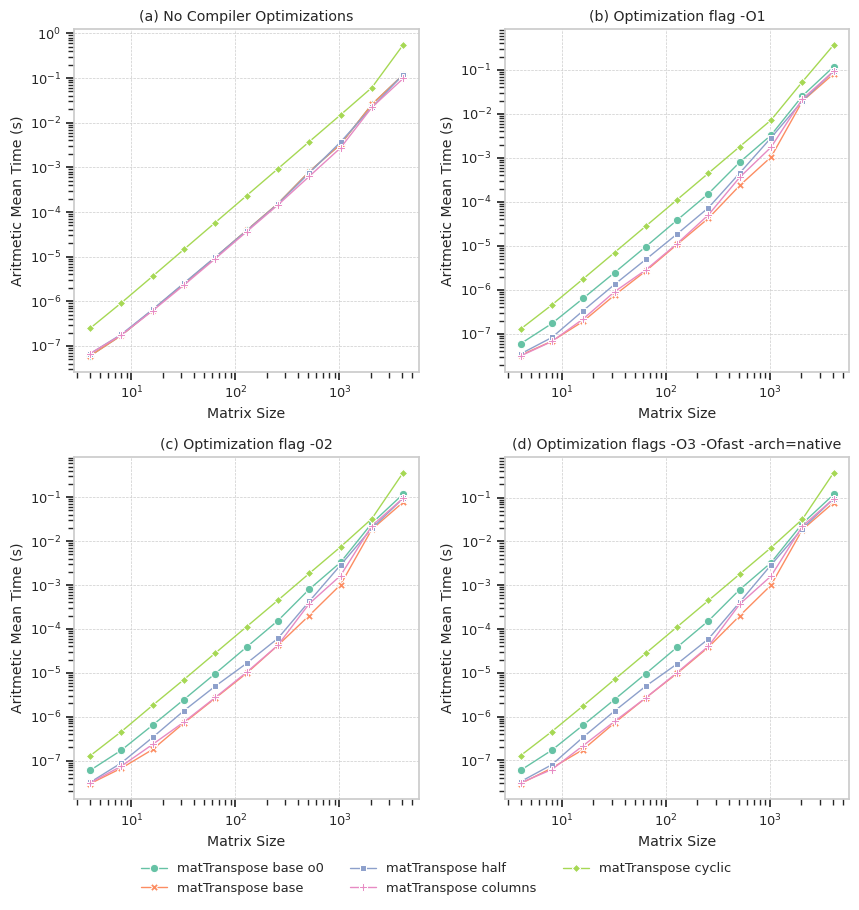

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_base_o0]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('(a) No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)

lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_base_o1]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('(b) Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_base_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('(c) Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_base_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('(d) Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Aritmetic Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
fig.savefig("../images/transpose_base.svg", format='svg', bbox_inches='tight') 

## Roofline

In [4]:
# Calcualte values
checkSymm['flops'] = checkSymm.apply(lambda row: row.space * (row.space + 1) / 2, axis=1)
checkSymm['flopss'] = checkSymm.apply(lambda row: data.flopss(row.flops, row['mean']), axis=1)
checkSymm['op_intensity'] = checkSymm.apply(lambda row: data.operational_intensity(row.flops, row.space**2/2 * 4 * 2), axis=1) # 2 accesses of 4 bytes

# performance_peak: float = data.performance_peak(cluster_data.core_count, cluster_data.clock_speed, cluster_data.flops_per_cycle) # GFLOPS
performance_peak = 422.7 * 10e3 / 7674 # GLOPS / TOTCORES IN CLUSTER
memory_peak: float = cluster_data.peak_theoretical_bandwidth
ridge: float = data.roofing_ridge(performance_peak, memory_peak)

checkSymm['performance'] = checkSymm.apply(lambda row: data.attainable_performance(memory_peak, row.op_intensity, performance_peak), axis=1)

print('Performance Peak: ', performance_peak)
print('Memory Peak: ', memory_peak)
print('Ridge: ', ridge)
# print(checkSymm)

# roofline data
operational_intensity = np.logspace(-2, 2, 50)  # generate a bunch of data for the x axys
df_roofline = pd.DataFrame({
    'name': 'roofline',
    'op_intensity': operational_intensity,
    'performance':  memory_peak * operational_intensity
})

df_roofline['performance'] = np.minimum(df_roofline['performance'], performance_peak)
#print(df_roofline[307:])

Performance Peak:  550.8209538702112
Memory Peak:  42.94967296
Ridge:  12.82479972276397


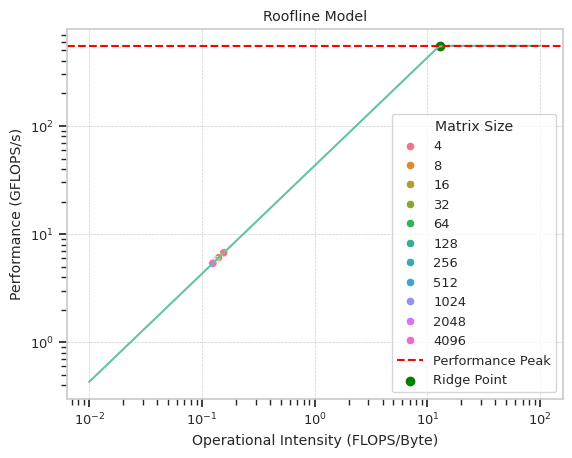

In [5]:
# plot
cs_legend = checkSymm.copy()
cs_legend['space'] = cs_legend['space'].astype('category')
sns.lineplot(
    data=df_roofline, hue='name',
    x="op_intensity", y="performance", legend=False,
)
sp = sns.scatterplot(
    data=cs_legend, hue='space',
    x="op_intensity", y="performance", legend=True, 
)
# Performance peak line
plt.axhline(y=performance_peak, color='red', linestyle='--', label='Performance Peak')
# Ridge point
plt.scatter(ridge, ridge*memory_peak, color='green', label='Ridge Point')
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')
plt.title('Roofline Model')
plt.xlabel('Operational Intensity (FLOPS/Byte)')
plt.ylabel('Performance (GFLOPS/s)')
plt.legend(title='Matrix Size', loc='lower right')
plt.savefig("../images/transpose_roofline.svg", format='svg') 
plt.show()

# Implicit Parallelism

In [6]:
checkSymm_implicit_o0 = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose vectorization', 'matTranspose unrolling outer',  \
                                                      'matTranspose unrolling inner', 'matTranspose cyclic unrolled', 'matTranspose intrinsic', 'matTranspose intrinsic cyclic'])].copy()
checkSymm_implicit_o1 = raw_data_o1.loc[raw_data_o1.name.isin(['matTranspose vectorization', 'matTranspose unrolling outer',  \
                                                      'matTranspose unrolling inner', 'matTranspose cyclic unrolled', 'matTranspose intrinsic', 'matTranspose intrinsic cyclic'])].copy()
checkSymm_implicit_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['matTranspose vectorization', 'matTranspose unrolling outer',  \
                                                      'matTranspose unrolling inner', 'matTranspose cyclic unrolled', 'matTranspose intrinsic', 'matTranspose intrinsic cyclic'])].copy()
checkSymm_implicit_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['matTranspose vectorization', 'matTranspose unrolling outer',  \
                                                      'matTranspose unrolling inner', 'matTranspose cyclic unrolled', 'matTranspose intrinsic', 'matTranspose intrinsic cyclic'])].copy()

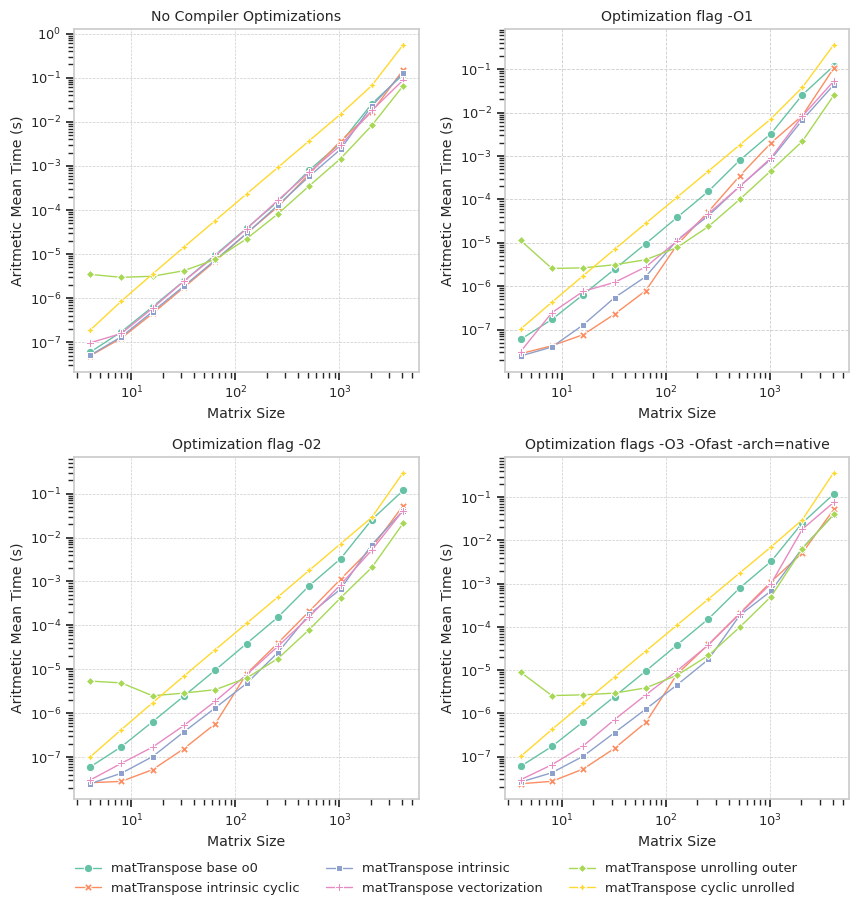

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_implicit_o0]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)


# TODO
lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_implicit_o1]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.6)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_implicit_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_implicit_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Aritmetic Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
fig.savefig("../images/transpose_implicit.svg", format='svg') 

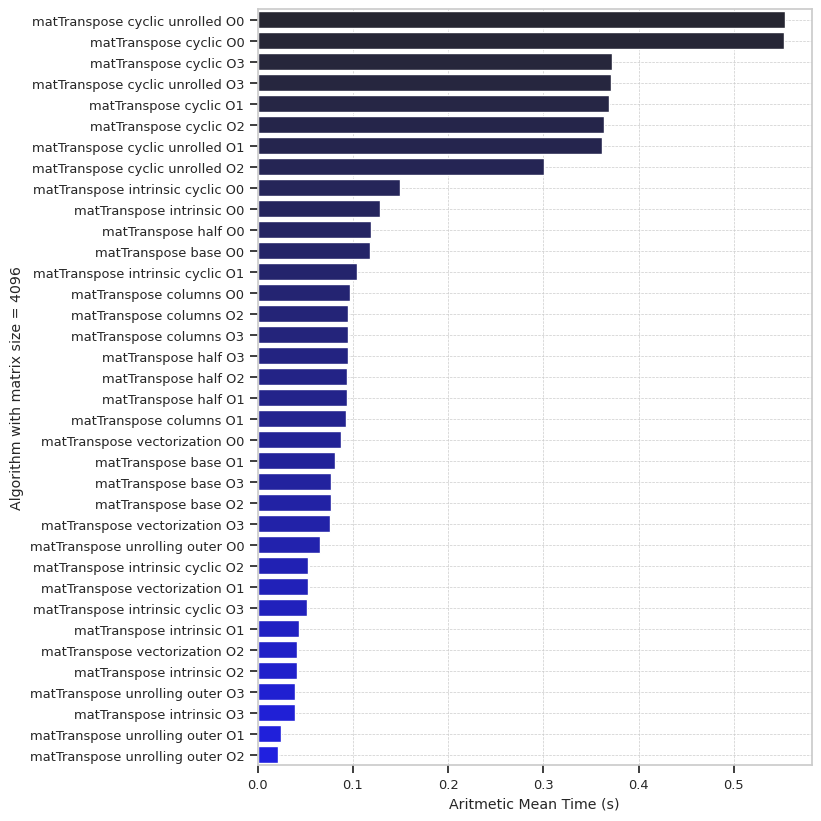

In [8]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85, rc={
    'xtick.bottom': True,
    'ytick.left': True,
    'figure.figsize':(8.27,8.27)
})
cs_base_o0 = checkSymm_base_o0.copy()
cs_base_o0['name'] = cs_base_o0.apply(lambda row: row['name'] + ' O0', axis=1)
cs_base_o1 = checkSymm_base_o1.copy()
cs_base_o1['name'] = cs_base_o1.apply(lambda row: row['name'] + ' O1', axis=1)
cs_base_o2 = checkSymm_base_o2.copy()
cs_base_o2['name'] = cs_base_o2.apply(lambda row: row['name'] + ' O2', axis=1)
cs_base_o3 = checkSymm_base_o3.copy()
cs_base_o3['name'] = cs_base_o3.apply(lambda row: row['name'] + ' O3', axis=1)

cs_imp_o0 = checkSymm_implicit_o0.copy()
cs_imp_o0['name'] = cs_imp_o0.apply(lambda row: row['name'] + ' O0', axis=1)
cs_imp_o1 = checkSymm_implicit_o1.copy()
cs_imp_o1['name'] = cs_imp_o1.apply(lambda row: row['name'] + ' O1', axis=1)
cs_imp_o2 = checkSymm_implicit_o2.copy()
cs_imp_o2['name'] = cs_imp_o2.apply(lambda row: row['name'] + ' O2', axis=1)
cs_imp_o3 = checkSymm_implicit_o3.copy()
cs_imp_o3['name'] = cs_imp_o3.apply(lambda row: row['name'] + ' O3', axis=1)

cs_all = pd.concat([cs_base_o0, cs_base_o1, cs_base_o2, cs_base_o3,
                                    cs_imp_o0, cs_imp_o1, cs_imp_o2, cs_imp_o3])
cs_cut = cs_all.loc[cs_all.space == 4096]
cs_cut = cs_cut.sort_values(by=['mean'], ascending=False)

sns.barplot(x="mean", y="name", data=cs_cut, errorbar=None,
            hue='name', orient='h', palette='dark:b')
sns.set(font_scale=0.7)
plt.ylabel('Algorithm with matrix size = 4096')
plt.xlabel('Aritmetic Mean Time (s)')
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("../images/transpose_implicit_bars.svg", format='svg') 

# Explicit Parallelism

In [9]:
checkSymm_omp_o0 = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose omp 2','matTranspose omp 4','matTranspose omp 8', \
                                                         'matTranspose omp 16','matTranspose omp 32','matTranspose omp 64'])].copy()
checkSymm_omp_o1 = raw_data_o1.loc[raw_data_o1.name.isin(['matTranspose omp 2','matTranspose omp 4','matTranspose omp 8', \
                                                         'matTranspose omp 16','matTranspose omp 32','matTranspose omp 64'])].copy()
checkSymm_omp_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['matTranspose omp 2','matTranspose omp 4','matTranspose omp 8', \
                                                         'matTranspose omp 16','matTranspose omp 32','matTranspose omp 64'])].copy()
checkSymm_omp_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['matTranspose omp 2','matTranspose omp 4','matTranspose omp 8', \
                                                         'matTranspose omp 16','matTranspose omp 32','matTranspose omp 64'])].copy()

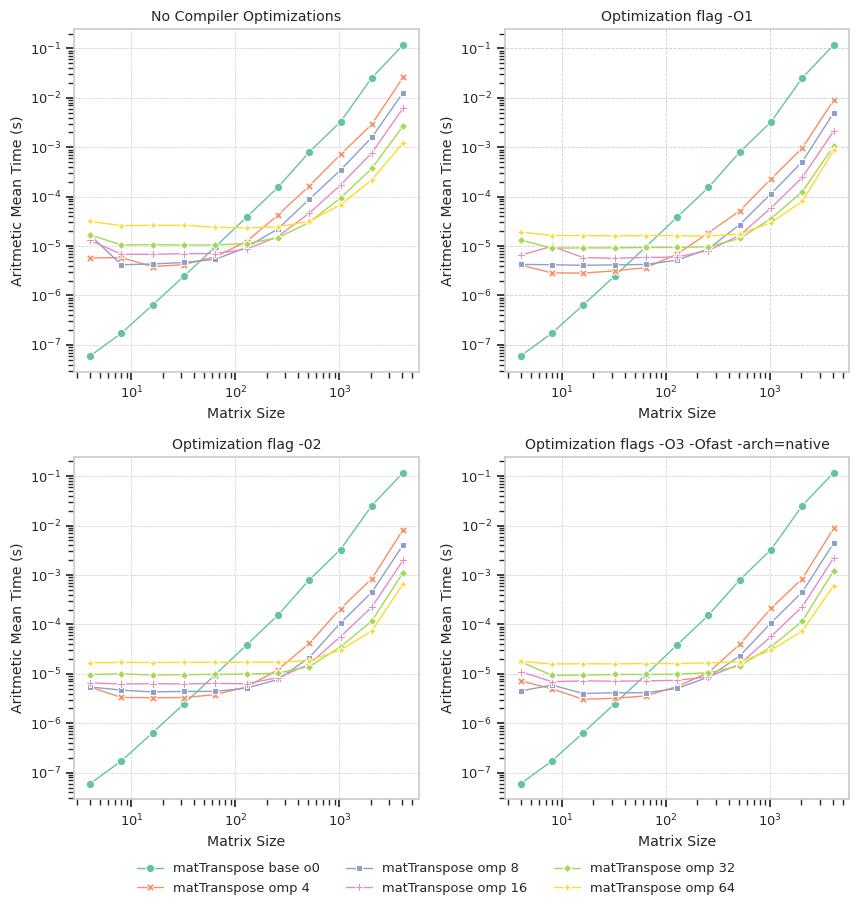

In [10]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85, rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o0]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)

lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o1]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.6)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Aritmetic Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
fig.savefig("../images/transpose_explicit.svg", format='svg') 

In [11]:
checkSymm_omp_collapse_o0 = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose omp 2 collapse','matTranspose omp 4 collapse','matTranspose omp 8 collapse', \
                                                         'matTranspose omp 16 collapse','matTranspose omp 32 collapse','matTranspose omp 64 collapse'])].copy()
checkSymm_omp_collapse_o1 = raw_data_o1.loc[raw_data_o1.name.isin(['matTranspose omp 2 collapse','matTranspose omp 4 collapse','matTranspose omp 8 collapse', \
                                                         'matTranspose omp 16 collapse','matTranspose omp 32 collapse','matTranspose omp 64 collapse'])].copy()
checkSymm_omp_collapse_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['matTranspose omp 2 collapse','matTranspose omp 4 collapse','matTranspose omp 8 collapse', \
                                                         'matTranspose omp 16 collapse','matTranspose omp 32 collapse','matTranspose omp 64 collapse'])].copy()
checkSymm_omp_collapse_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['matTranspose omp 2 collapse','matTranspose omp 4 collapse','matTranspose omp 8 collapse', \
                                                         'matTranspose omp 16 collapse','matTranspose omp 32 collapse','matTranspose omp 64 collapse'])].copy()

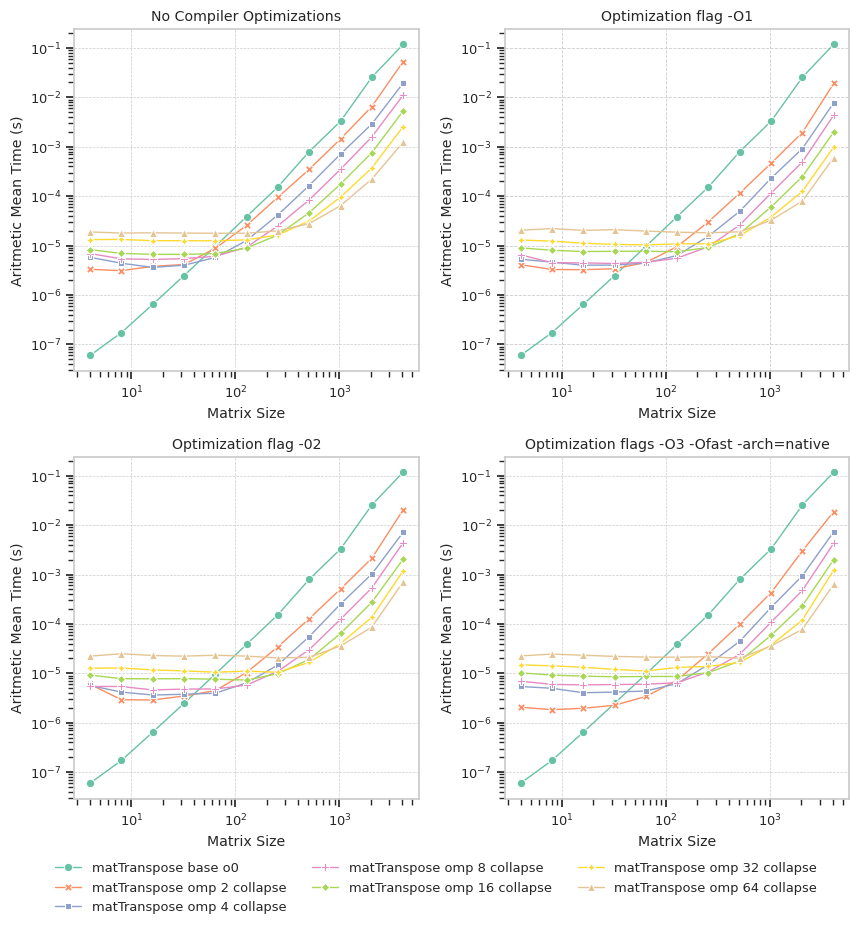

In [12]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85, rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_collapse_o0]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)

lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_collapse_o1]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.6)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_collapse_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_collapse_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Aritmetic Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
fig.savefig("../images/transpose_explicit_collapse.svg", format='svg') 

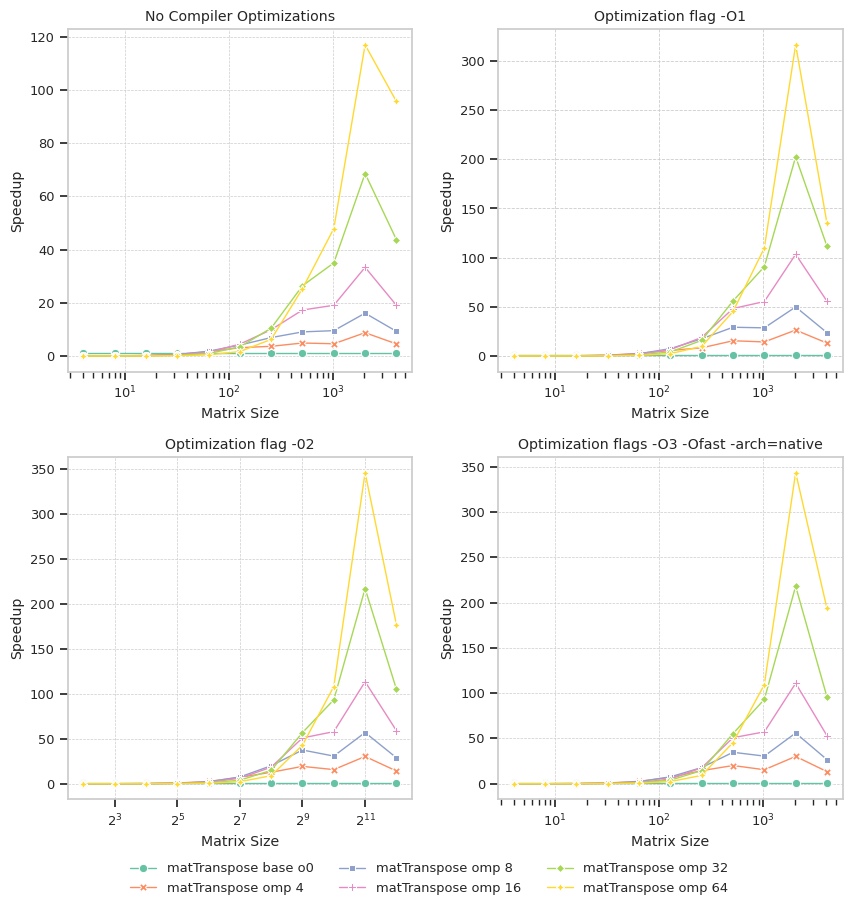

In [13]:
checkSymm['speedup'] = checkSymm.apply(lambda row: 1, axis=1).copy()
checkSymm_omp_o0['speedup'] = checkSymm_omp_o0.apply(lambda row: 1 / (row['mean'] / checkSymm.loc[checkSymm.space == row.space, 'mean'].iloc[0]), axis=1).copy()
checkSymm_omp_o1['speedup'] = checkSymm_omp_o1.apply(lambda row: 1 / (row['mean'] / checkSymm.loc[checkSymm.space == row.space, 'mean'].iloc[0]), axis=1).copy()
checkSymm_omp_o2['speedup'] = checkSymm_omp_o2.apply(lambda row: 1 / (row['mean'] / checkSymm.loc[checkSymm.space == row.space, 'mean'].iloc[0]), axis=1).copy()
checkSymm_omp_o3['speedup'] = checkSymm_omp_o3.apply(lambda row: 1 / (row['mean'] / checkSymm.loc[checkSymm.space == row.space, 'mean'].iloc[0]), axis=1).copy()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o0]),
    x="space", y="speedup", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

# axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Speedup')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)

lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o1]),
    x="space", y="speedup", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
# axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Speedup')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.6)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o2]),
    x="space", y="speedup", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
# axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log', base=2)
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Speedup')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o3]),
    x="space", y="speedup", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
# axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Speedup')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show
fig.savefig("../images/transpose_explicit_speedup.svg", format='svg') 

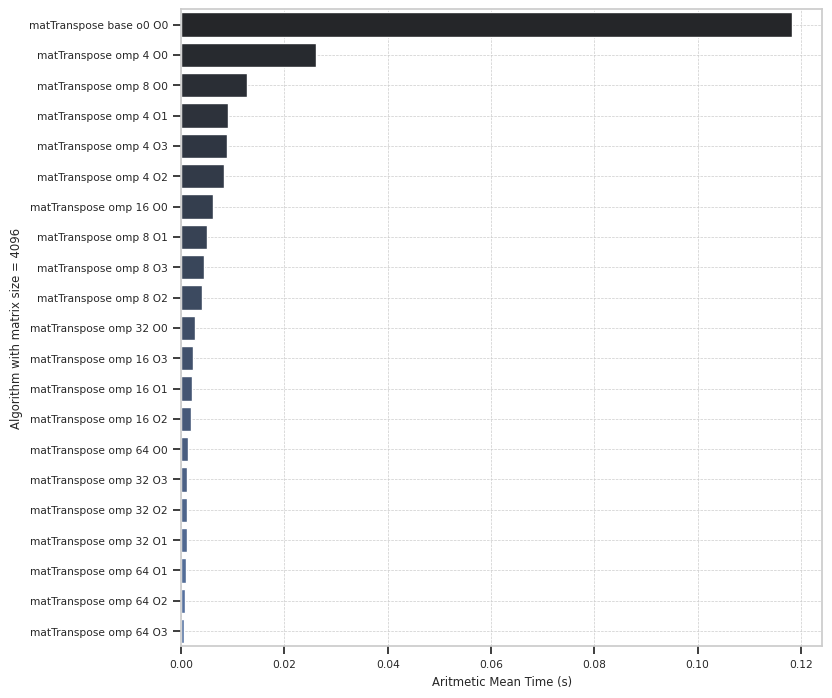

In [14]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.7, rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

cs_base_o0 = checkSymm.copy()
cs_base_o0['name'] = cs_base_o0.apply(lambda row: row['name'] + ' O0', axis=1)

cs_omp_o0 = checkSymm_omp_o0.copy()
cs_omp_o0['name'] = cs_omp_o0.apply(lambda row: row['name'] + ' O0', axis=1)
cs_omp_o1 = checkSymm_omp_o1.copy()
cs_omp_o1['name'] = cs_omp_o1.apply(lambda row: row['name'] + ' O1', axis=1)
cs_omp_o2 = checkSymm_omp_o2.copy()
cs_omp_o2['name'] = cs_omp_o2.apply(lambda row: row['name'] + ' O2', axis=1)
cs_omp_o3 = checkSymm_omp_o3.copy()
cs_omp_o3['name'] = cs_omp_o3.apply(lambda row: row['name'] + ' O3', axis=1)

cs_all = pd.concat([cs_base_o0, cs_omp_o0, cs_omp_o1, cs_omp_o2, cs_omp_o3])
cs_cut = cs_all.loc[cs_all.space == 4096]
cs_cut = cs_cut.sort_values(by=['mean'], ascending=False)

sns.barplot(x="mean", y="name", data=cs_cut, errorbar=None,
            hue='name', orient='h', palette='dark:b')
plt.ylabel('Algorithm with matrix size = 4096')
plt.xlabel('Aritmetic Mean Time (s)')
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.savefig("../images/transpose_explicit_bar.svg", format='svg') 

## Schedulers

In [15]:
checkSymm_omp_sched_o0 = raw_data_o0.loc[raw_data_o0.name.isin(['matTranspose omp 16 sched static','matTranspose omp 16 sched dynamic', \
                                                               'matTranspose omp 16 sched guided'])].copy()
checkSymm_omp_sched_o1 = raw_data_o1.loc[raw_data_o1.name.isin(['matTranspose omp 16 sched static','matTranspose omp 16 sched dynamic', \
                                                               'matTranspose omp 16 sched guided'])].copy()
checkSymm_omp_sched_o2 = raw_data_o2.loc[raw_data_o2.name.isin(['matTranspose omp 16 sched static','matTranspose omp 16 sched dynamic', \
                                                               'matTranspose omp 16 sched guided'])].copy()
checkSymm_omp_sched_o3 = raw_data_o3.loc[raw_data_o3.name.isin(['matTranspose omp 16 sched static','matTranspose omp 16 sched dynamic', \
                                                               'matTranspose omp 16 sched guided'])].copy()

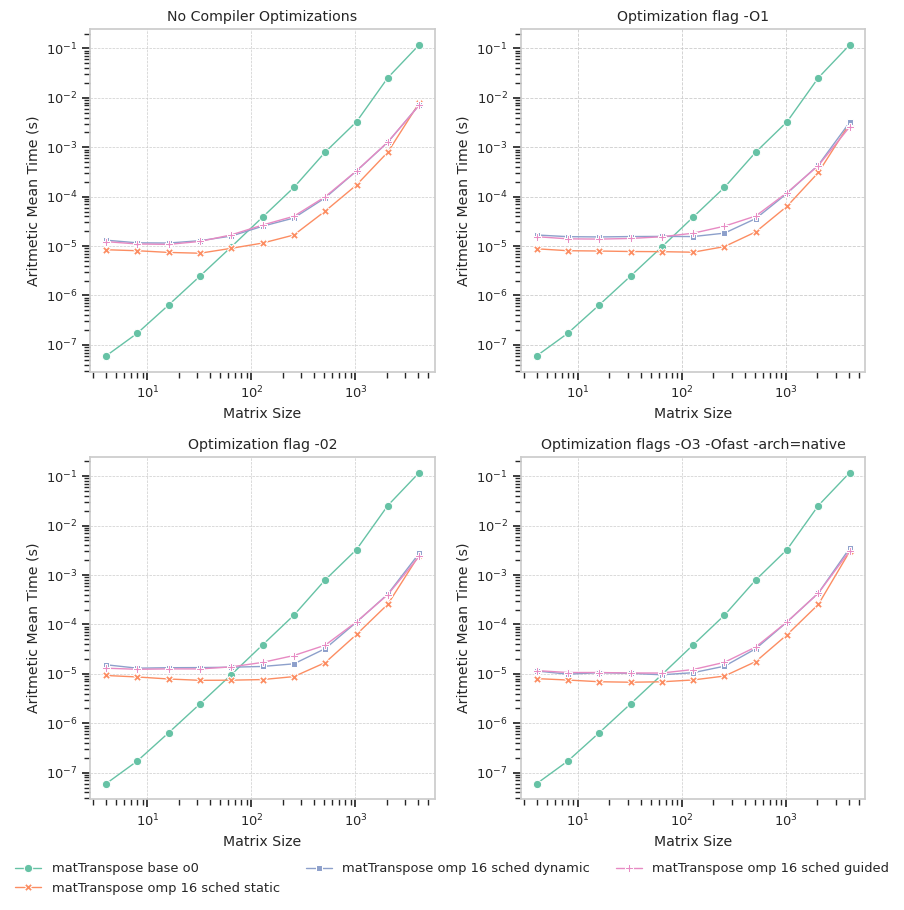

In [16]:
sns.set_theme(style="whitegrid", palette="Set2", font_scale=0.85, rc={
    'xtick.bottom': True,
    'ytick.left': True,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_sched_o0]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('No Compiler Optimizations')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)


# TODO
lp2 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_sched_o1]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1], legend=False,
    linewidth = 1
)
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('Optimization flag -O1')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(which='major', linestyle='--', linewidth=0.6)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_sched_o2]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0], legend=False,
    linewidth = 1
)
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('Optimization flag -02')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(which='major', linestyle='--', linewidth=0.5)

lp3 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_sched_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][1], legend=False,
    linewidth = 1
)
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_title('Optimization flags -O3 -Ofast -arch=native')
axes[1][1].set_xlabel('Matrix Size')
axes[1][1].set_ylabel('Aritmetic Mean Time (s)')
axes[1,1].grid(which='major', linestyle='--', linewidth=0.5)

sns.move_legend(
    lp1, "upper center",
    bbox_to_anchor=(1.05, -1.4), ncol=3, title="", frameon=False,
)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()
fig.savefig("../images/transpose_sched.svg", format='svg') 

# Amalgamated

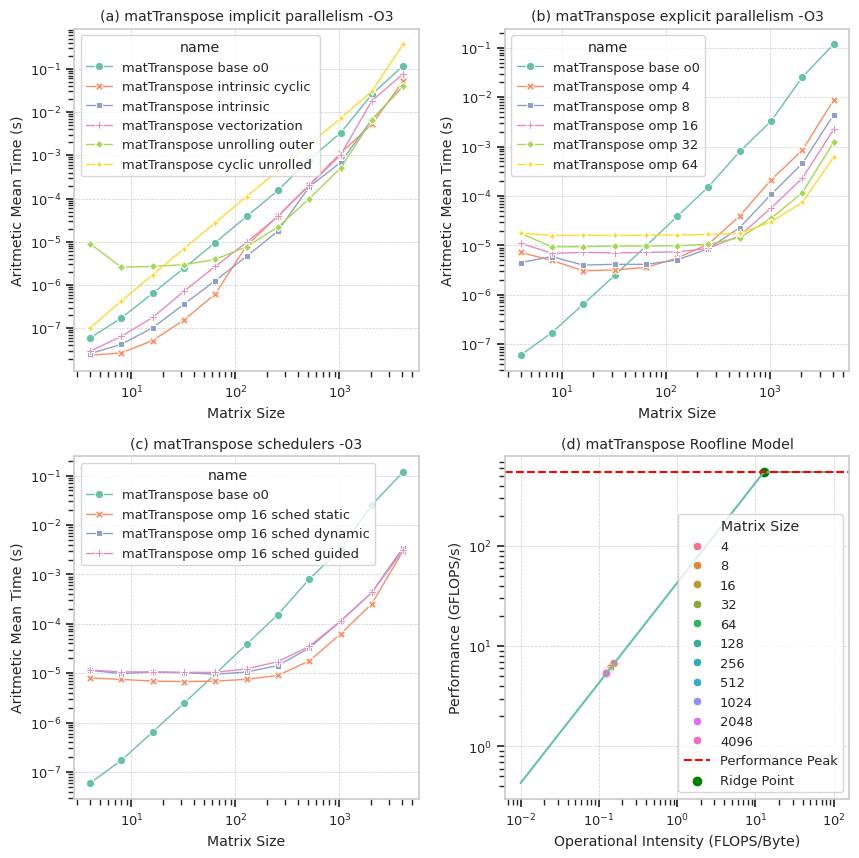

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_implicit_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][0],
    linewidth = 1
)

axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_title('(a) matTranspose implicit parallelism -O3')
axes[0][0].set_xlabel('Matrix Size')
axes[0][0].set_ylabel('Aritmetic Mean Time (s)')
axes[0,0].grid(True, which='major', linestyle='--', linewidth=0.5)

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[0][1],
    linewidth = 1
)

axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_title('(b) matTranspose explicit parallelism -O3')
axes[0][1].set_xlabel('Matrix Size')
axes[0][1].set_ylabel('Aritmetic Mean Time (s)')
axes[0,1].grid(True, which='major', linestyle='--', linewidth=0.5)

lp1 = sns.lineplot(
    data=pd.concat([checkSymm, checkSymm_omp_sched_o3]),
    x="space", y="mean", hue="name", style="name",
    markers=True, dashes=False, ax=axes[1][0],
    linewidth = 1
)

axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_title('(c) matTranspose schedulers -03')
axes[1][0].set_xlabel('Matrix Size')
axes[1][0].set_ylabel('Aritmetic Mean Time (s)')
axes[1,0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Roofline
cs_legend = checkSymm.copy()
cs_legend['space'] = cs_legend['space'].astype('category')
sns.lineplot(
    data=df_roofline, hue='name',
    x="op_intensity", y="performance", legend=False,
)
sp = sns.scatterplot(
    data=cs_legend, hue='space',
    x="op_intensity", y="performance", legend=True, 
)
# Performance peak line
plt.axhline(y=performance_peak, color='red', linestyle='--', label='Performance Peak')
# Ridge point
plt.scatter(ridge, ridge*memory_peak, color='green', label='Ridge Point')
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

axes[1][1].set_xscale('log')
axes[1][1].set_yscale('log')
axes[1][1].set_title('(d) matTranspose Roofline Model')
axes[1][1].set_xlabel('Operational Intensity (FLOPS/Byte)')
axes[1][1].set_ylabel('Performance (GFLOPS/s)')
axes[1][1].legend(title='Matrix Size', loc='lower right')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
fig.savefig("../images/transpose_all.svg", format='svg', bbox_inches='tight') 
plt.show()